### Q1

__Kernel SVM__

From  sklearn  import  the  Breast  Cancer  dataset.   Draw  the  contour plots generated by fitting an SVM with the following kernels to the data (you can use sklearn’s implementation of SVM):

- (a)  Linear kernel
- (b)  Radial Basis Function (RBF) kernel
- (c)  Polynomial kernel of degree 5



#### load breast cancer data from sklearn

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

cancer = load_breast_cancer()
X = cancer.data[:, :2]
labels = cancer.target

In [2]:
def plot_contour(x, 
                 y, 
                 labels,
                 models,
                 row,
                 col,
                 figsize,
                 cmap1,
                 cmap2,
                 titles,
                 multiple=True):
    # meshgrid
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    fig, sub = plt.subplots(row,
                            col, 
                            figsize=figsize)
    try:
        s = sub.flatten()
    except Exception as e:
        print(e)
        s = sub
    for model, title, ax in zip(models, titles, s):
        Xy = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Xy = Xy.reshape(xx.shape)
        ax.contourf(xx, yy, Xy, cmap=cmap1)
        ax.scatter(x, y, c=labels, s=50, cmap=cmap2)
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_title(title)
    plt.show()

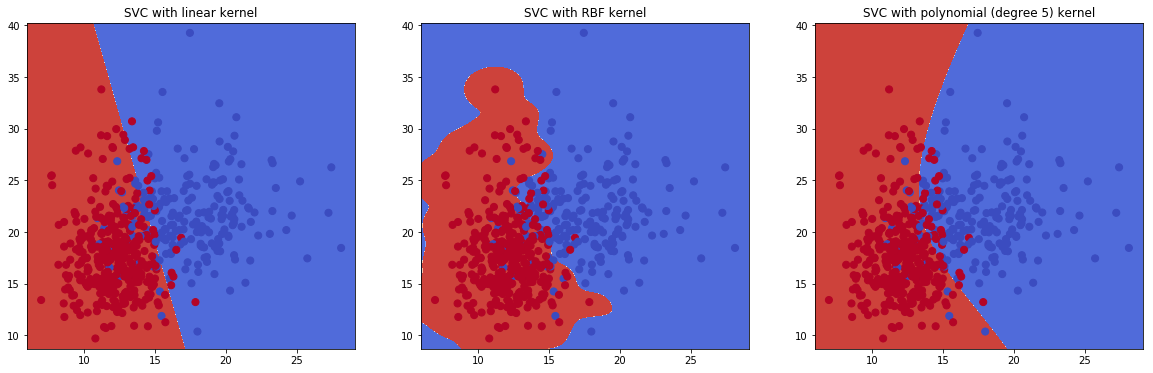

In [3]:
FIGSIZE = (20,6)
models = (SVC(kernel='linear'),
          SVC(kernel='rbf'),
          SVC(kernel='poly', degree=4) # if the degree of polynomial kernel is set as 5, the running time is way too long since the time complexity increases
         )
models = (clf.fit(X, labels) for clf in models)

TITLES = ('SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 5) kernel')

plot_contour(x=X[:, 0],
             y=X[:, 1],
             labels=labels,
             models=models,
             row=1,
             col=3,
             figsize=FIGSIZE,
             cmap1=plt.cm.coolwarm,
             cmap2=plt.cm.coolwarm,
             titles=TITLES)

## Q2

__Kernel logistic regression__  

In this exercise,  we're interested in using RBF kernel in  logistic  regression.   Report  the  average  area  under  curve  (AUC)  of  10-fold  cross-validation  (where  in  each  fold  you  use  20%  of  the  data  for  testing)  on  the  Breast Cancer dataset using RBF logistic regression (you can use sklearn implementations).

0.10193321616871705
0.10193321616871705
0.10017574692442882
0.10017574692442882
0.10017574692442882
0.10017574692442882
0.10017574692442882
0.0984182776801406
0.0984182776801406
0.0984182776801406


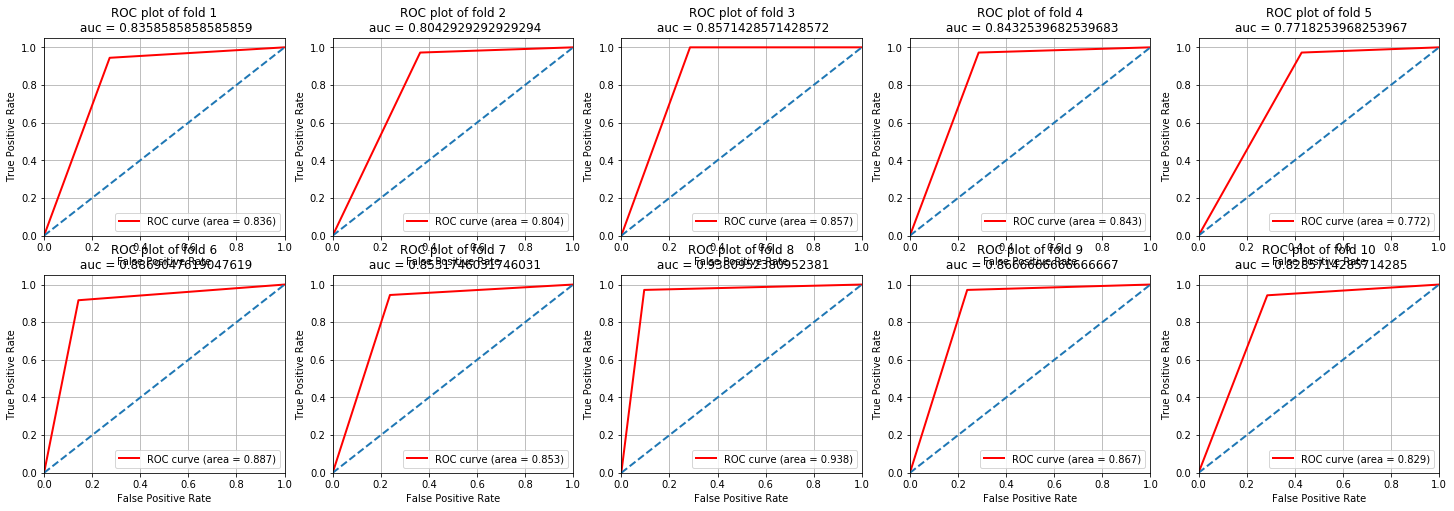

In [4]:
X = cancer.data
labels = cancer.target

def rbf_kernel(x, mean, sd):
    return np.exp(-1/(2*sd**2)*(x-mean)**2)


def evaluate(X_train, X_test, y_train, y_test, fold):
    clf = LogisticRegression(solver='lbfgs')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    auc_value = auc(fpr, tpr)
    plot_roc(fpr, tpr, auc_value, fold=fold)

def plot_roc(fpr, tpr, auc_value, fold=None):
    plt.subplot(2,5,fold)
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.3f)' % auc_value)
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if fold != None:
        plt.title('ROC plot of fold {}\n auc = {}'.format(fold, auc_value))
    else:
        plt.title('ROC plot, auc = {}'.format(auc_value))
    plt.legend(loc="lower right")
    plt.grid(True)

def k_fold_evaluate(X, y):
    # initialization
    accuracy = []
    precision = []
    recall=[]
    f1 = []
    fold = 1
    skf = StratifiedKFold(n_splits=10, random_state=100, shuffle= True)
    
    # rbf
    X = rbf_kernel(X, 0, 1)
    for train_index, test_index in skf.split(X, y):
        print(len(test_index)/(len(X)))
        X_train, X_test, y_train, y_test = X[train_index, :], X[test_index, :], y[train_index], y[test_index]
        evaluate(X_train, X_test, y_train, y_test, fold)
        fold += 1
        
plt.figure(figsize=(25, 8))     
k_fold_evaluate(X, labels)
plt.show()

## Q3

__Soft-margin kernel SVM__

Implement  soft-margin SVM with a linear kernel, optimize the objective function according to slides #119-120 of the lecture slides on ”Lectures 15-16 Maximum Margin Linear Classifiers” onthe course website.1Fit your implemented classifier to the Breast Cancer dataset anddraw the contour plot similar to question 1.

$$J(w, b) = \frac{1}{2}w^TXw + C\sum^m_{i=1} \max(0, 1-y_i (X_i \cdot w + b)) $$

__Derivative:__

$$\frac{\partial J}{\partial w} = C \sum^m_{i=1} \mathbb{I} (y_i (X_i \cdot w +b)<1) \cdot (-y_i X_i) + X_i w$$


$$\frac{\partial J}{\partial b} = C \sum_{i=1}^m \mathbb{I} (y_i (X_i \cdot w +b)<1) \cdot (-y_i)$$

__Update:__

$$w \leftarrow w - \eta \frac{\partial J}{\partial w}$$

$$b \leftarrow b - \eta \frac{\partial J}{\partial b}$$


#### Augmented matrix $[w, b]$:

$$J(w, b) = \frac{1}{2}w^TXw + C\sum^{m}_{i=1} \max(0, 1-y_i (X_i \cdot w )) $$


$$\frac{\partial J}{\partial w} = C \sum^{m+1}_{i=1} \mathbb{I} (y_i (X_i \cdot w )<1) \cdot (-y_i X_i) + X_i w$$

In [11]:
import numpy as np

class SoftMarginSVM:
    def __init__(self,
                 X,
                 y,
                 C=3,
                 learning_rate=0.001,
                 n_iter=100000):
        # augmented matrix X = [w, b]
        self.X = np.hstack([X, np.ones([X.shape[0],1])])
        self.y = np.where(y==0, -1, 1) # original y is (0,1), otherwise 
        self.n_sample=self.X.shape[0]
        self.n_features=self.X.shape[1]
        self.W=np.random.random(self.n_features)-0.5
        self.C=C
        self.learning_rate=learning_rate
        self.n_iter=n_iter
        
    def loss_func(self):
        hinge_loss = np.maximum(0,1-self.y*np.dot(self.X,self.W))
        slack_term = hinge_loss.mean()*self.C
        w = self.W[:-1]
        cost_f = 0.5*np.sum(w**2)
        return cost_f + slack_term

    def d_obj_func(self):
        I=np.where(self.y*np.dot(self.X,self.W)>=1, 0, -1)[:,None]
        dJ=np.zeros(self.W.shape)
        dJ[:-1]=(I*self.X[:,:-1]*(np.array(self.y)[:,np.newaxis])).mean(axis=0)*self.C+self.W[:-1] 
        dJ[-1]=(I*self.C*(np.array(self.y)[:,np.newaxis])).mean(axis=0)                     
        return dJ

    def train(self):
        loss=[]
        for iter_ in range(self.n_iter):
            dJ=self.d_obj_func()
            self.W = self.W - self.learning_rate*dJ
            loss_per_iter = self.loss_func()
            loss.append(loss_per_iter)
            if iter_%10000 == 0:
                print('dJ:', dJ)
                print('W =', self.W)
                print('loss at iter {}:'.format(iter_), loss_per_iter)
        self.losses=loss


    def predict(self,x):
        # augmented matrix X = [w, b]
        x = np.hstack([x,np.ones([x.shape[0],1])])
        y_preds=[]
        for i in x:
            y_pred=1 if np.sign(i.dot(self.W))>=0 else -1
            y_preds.append(y_pred)
        return np.array(y_preds)

In [12]:
X = cancer.data[:, :2]  # choose the first and the second attribute of the cancer dataset for display convenience
labels = cancer.target

softsvm_gd = SoftMarginSVM(X,labels)
softsvm_gd.train()

svm_sklearn=SVC(C=3,kernel='linear')
svm_sklearn.fit(X,labels)

print('not sklearn svm weights:', softsvm_gd.W)
print('sklearn svm weights:', svm_sklearn.coef_, 
      'sklearn svm bias:', svm_sklearn.intercept_)

dJ: [-22.51851413 -34.10461491  -1.87697715]
W = [ 0.27194288 -0.40518517 -0.38995415]
loss at iter 0: 10.197775556725839
dJ: [ 0.1525213   0.26729056 -0.25307557]
W = [-0.218756    0.03197933  2.92276817]
loss at iter 10000: 1.4571878325512568
dJ: [-0.04701623 -0.1151632  -0.12126538]
W = [-0.27320823 -0.01856297  4.69542547]
loss at iter 20000: 1.1216270517230464
dJ: [-0.43214622 -0.6135725  -0.10544815]
W = [-0.30628349 -0.04121903  5.60125148]
loss at iter 30000: 1.0382112681425946
dJ: [ 0.01957028  0.02978119 -0.05272408]
W = [-0.33449147 -0.0552398   6.23444656]
loss at iter 40000: 0.9975622482226898
dJ: [ 0.03525597  0.03339776 -0.03690685]
W = [-0.35267032 -0.06475514  6.68968733]
loss at iter 50000: 0.9765227882654229
dJ: [ 0.18642668  0.21118287 -0.01581722]
W = [-0.36398822 -0.07168209  7.01295447]
loss at iter 60000: 0.9659173457701415
dJ: [-0.08101796 -0.09323944 -0.02636204]
W = [-0.37329195 -0.07748715  7.26378399]
loss at iter 70000: 0.9595615904269845
dJ: [ 0.00758086 

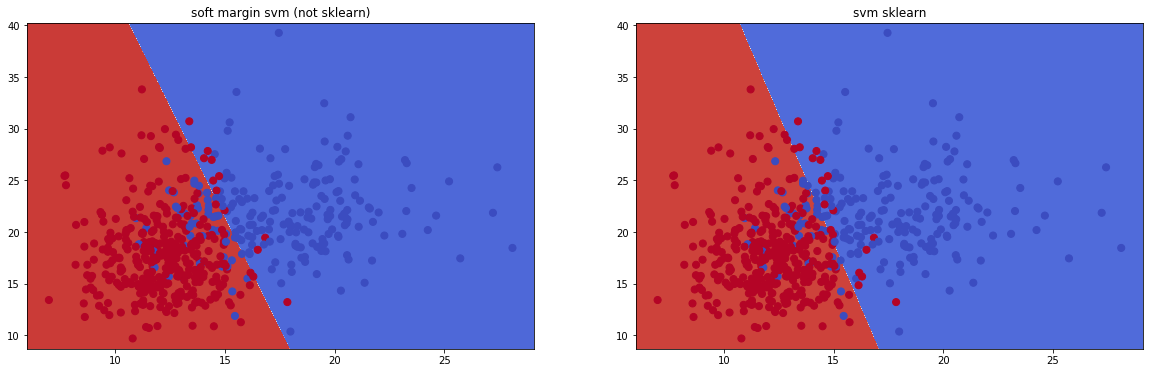

In [13]:
## plot result
plot_contour(x=X[:, 0],
             y=X[:, 1],
             labels=labels,
             models=(
                     softsvm_gd,
                     svm_sklearn
                    ),
             row=1,
             col=2,
             figsize=FIGSIZE,
             cmap1=plt.cm.coolwarm, 
             cmap2=plt.cm.coolwarm,
             titles=(
                    'soft margin svm (not sklearn)',
                     'svm sklearn'
                     ))